<a href="https://colab.research.google.com/github/Hrithik2212/Road-Sign-Detection/blob/main/00_Road_Sign_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Road Sign Detection 


## Data Wrangling 

In [28]:
import os
if not os.path.exists('GTSRB'):
    !pip install -U -q torch_snippets
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
    !unzip -qq GTSRB_Final_Training_Images.zip
    !unzip -qq GTSRB_Final_Test_Images.zip
    !wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
    !rm GTSRB_Final_Training_Images.zip GTSRB_Final_Test_Images.zip    

## Data Exploration and Preparation 

In [29]:
from torch_snippets import *
classIds = pd.read_csv('signnames.csv')
classIds.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [30]:
classIds.set_index('ClassId',inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

In [31]:
classIds

{'0': 'Speed limit (20km/h)',
 '1': 'Speed limit (30km/h)',
 '2': 'Speed limit (50km/h)',
 '3': 'Speed limit (60km/h)',
 '4': 'Speed limit (70km/h)',
 '5': 'Speed limit (80km/h)',
 '6': 'End of speed limit (80km/h)',
 '7': 'Speed limit (100km/h)',
 '8': 'Speed limit (120km/h)',
 '9': 'No passing',
 '10': 'No passing for vechiles over 3.5 metric tons',
 '11': 'Right-of-way at the next intersection',
 '12': 'Priority road',
 '13': 'Yield',
 '14': 'Stop',
 '15': 'No vechiles',
 '16': 'Vechiles over 3.5 metric tons prohibited',
 '17': 'No entry',
 '18': 'General caution',
 '19': 'Dangerous curve to the left',
 '20': 'Dangerous curve to the right',
 '21': 'Double curve',
 '22': 'Bumpy road',
 '23': 'Slippery road',
 '24': 'Road narrows on the right',
 '25': 'Road work',
 '26': 'Traffic signals',
 '27': 'Pedestrians',
 '28': 'Children crossing',
 '29': 'Bicycles crossing',
 '30': 'Beware of ice/snow',
 '31': 'Wild animals crossing',
 '32': 'End of all speed and passing limits',
 '33': 'Turn 

In [32]:
from torchvision.transforms.transforms import ColorJitter
from torchvision import transforms as T

trn_tfms = T.Compose([
            T.ToPILImage(),
            T.Resize(32),
            T.CenterCrop(32),
            T.ColorJitter(brightness = (0.8,1.2),
                          contrast = (0.8,1.2),
                          hue = 0.25),
            T.RandomAffine(5,translate=(0.01,0.1)),
            T.ToTensor(),
            T.Normalize(mean=[0.485 , 0.456 , 0.406],
                        std = [0.229,0.224,0.225])
            ])

val_tfms = T.Compose([
                      T.ToPILImage(),
                      T.Resize(32),
                      T.CenterCrop(32),
                      T.ToTensor(),
                      T.Normalize(mean=[0.485 , 0.456 , 0.406],
                        std = [0.229,0.224,0.225])
])

In [56]:
class GTSRB(Dataset):
  def __init__(self , files , transform = None):
    self.files = files
    self.transform = transform
    logger.info(len(self))
  
  def __len__(self):
    return len(self.files)

  def __getitem__(self , ix):
    fpath = self.files[ix]
    clss = str(int(fname(parent(fpath))))
    img = read(fpath , 1)
    return img , classIds[clss]

  def choose(self):
    return self[randint(len(self))]

  def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes

device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('/content/GTSRB/Final_Training/*/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split 
trn_files , val_files = train_test_split(all_files ,random_state=1)

train_ds = GTSRB(trn_files , transform = trn_tfms)
val_ds = GTSRB(val_files , transform =  val_tfms)
train_dl = DataLoader(train_ds , 32  ,shuffle=True , collate_fn = train_ds.collate_fn)
val_dl = DataLoader(val_ds , 32  ,shuffle=False , collate_fn = train_ds.collate_fn)

[09/10/22 05:41:33] INFO     29406                                       ]8;id=423080;file://<ipython-input-56-20bbfa2756fd>\<ipython-input-56-20bbfa2756fd>]8;;\:]8;id=95904;file://<ipython-input-56-20bbfa2756fd>#__init__:5\__init__:5]8;;\

                    INFO     9803                                        ]8;id=550107;file://<ipython-input-56-20bbfa2756fd>\<ipython-input-56-20bbfa2756fd>]8;;\:]8;id=442051;file://<ipython-input-56-20bbfa2756fd>#__init__:5\__init__:5]8;;\

In [43]:
len(all_files)

39209

## Model Building 

In [47]:
def conv_block(ni,no):
  return  nn.Sequential(
      nn.Dropout(0.2),
      nn.Conv2d(ni,no,kernel_size = 3,padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2),
  )

class SignClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
                        conv_block(3,64),
                        conv_block(64,64),
                        conv_block(64,128),
                        conv_block(128,64),
                        nn.Flatten(),
                        nn.Linear(256,256),
                        nn.Dropout(0.2),
                        nn.ReLU(),
                        nn.Linear(256 , len(id2int)))
    self.loss_fn = nn.CrossEntropyLoss()
  
  def forward(self , x ):
    return self.model(x)

  def compute_metrics(self, preds , targets):
    ce_loss = self.loss_fn(preds , targets)
    acc  = (torch.max(preds,1)[1]==targets).float().mean()
    return ce_loss , acc 

In [48]:
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

In [57]:
device

'cuda'

In [58]:
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [94]:
from torchsummary import summary
summary(model , (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 64, 32, 32]           1,792
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
           Dropout-5           [-1, 64, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          36,928
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
           Dropout-9             [-1, 64, 8, 8]               0
           Conv2d-10            [-1, 128, 8, 8]          73,856
             ReLU-11            [-1, 128, 8, 8]               0
        MaxPool2d-12            [-1, 128, 4, 4]               0
          Dropout-13            [-1, 128, 4, 4]               0
           Conv2d-14             [-1, 6

In [60]:
EPOCHS = 25 
train_loss , val_loss = [] , [] 
train_acc , val_acc = [] , []
for epoch in range(EPOCHS):
  print(f'EPOCH {epoch+1}')
  epoch_loss , epoch_acc = [] , []
  evl , eva = [] , [] 
  for bx , data in enumerate(train_dl):
    tloss , tacc = train_batch(model , data , optimizer , criterion)
    epoch_loss.append(tloss) , epoch_acc.append(tacc)
  train_loss.append(np.mean(epoch_loss)) , train_acc.append(np.mean(epoch_acc))

  for bx , data in enumerate(val_dl):
    vloss , vacc = validate_batch(model,data,criterion) 
    evl.append(vloss) , eva.append(vacc)
  val_loss.append(np.mean(evl)) , val_acc.append(np.mean(eva))

  print(f"Train Loss :{train_loss[epoch]:.4f} | Train Acc :{train_acc[epoch]:.2f} %" ,end=" | ")
  print(f"Val Loss :{val_loss[epoch]:.4f} | Val Acc :{val_acc[epoch]:.2f} %")
  print(f"=======================================Done")

EPOCH 1

Train Loss :2.8771 | Train Acc :0.20 % |

Val Loss :2.0398 | Val Acc :0.36 %

=======================================Done

EPOCH 2

Train Loss :1.6340 | Train Acc :0.49 % |

Val Loss :1.3610 | Val Acc :0.57 %

=======================================Done

EPOCH 3

Train Loss :1.1936 | Train Acc :0.62 % |

Val Loss :1.0998 | Val Acc :0.65 %

=======================================Done

EPOCH 4

Train Loss :0.9834 | Train Acc :0.69 % |

Val Loss :0.8887 | Val Acc :0.71 %

=======================================Done

EPOCH 5

Train Loss :0.8602 | Train Acc :0.72 % |

Val Loss :0.8383 | Val Acc :0.73 %

=======================================Done

EPOCH 6

Train Loss :0.7898 | Train Acc :0.74 % |

Val Loss :0.7847 | Val Acc :0.74 %

=======================================Done

EPOCH 7

Train Loss :0.7355 | Train Acc :0.76 % |

Val Loss :0.7258 | Val Acc :0.77 %

=======================================Done

EPOCH 8

Train Loss :0.6932 | Train Acc :0.78 % |

Val Loss :0.7295 | Val Acc :0.77 %

=======================================Done

EPOCH 9

Train Loss :0.6552 | Train Acc :0.79 % |

Val Loss :0.6461 | Val Acc :0.80 %

=======================================Done

EPOCH 10

Train Loss :0.6337 | Train Acc :0.80 % |

Val Loss :0.6178 | Val Acc :0.80 %

=======================================Done

EPOCH 11

Train Loss :0.6027 | Train Acc :0.81 % |

Val Loss :0.6227 | Val Acc :0.80 %

=======================================Done

EPOCH 12

Train Loss :0.5874 | Train Acc :0.81 % |

Val Loss :0.6310 | Val Acc :0.80 %

=======================================Done

EPOCH 13

Train Loss :0.5717 | Train Acc :0.81 % |

Val Loss :0.6226 | Val Acc :0.80 %

=======================================Done

EPOCH 14

Train Loss :0.5492 | Train Acc :0.82 % |

Val Loss :0.5508 | Val Acc :0.82 %

=======================================Done

EPOCH 15

Train Loss :0.5336 | Train Acc :0.83 % |

Val Loss :0.5406 | Val Acc :0.83 %

=======================================Done

EPOCH 16

Train Loss :0.5232 | Train Acc :0.83 % |

Val Loss :0.5377 | Val Acc :0.83 %

=======================================Done

EPOCH 17

Train Loss :0.5046 | Train Acc :0.84 % |

Val Loss :0.4803 | Val Acc :0.84 %

=======================================Done

EPOCH 18

Train Loss :0.4908 | Train Acc :0.84 % |

Val Loss :0.4772 | Val Acc :0.85 %

=======================================Done

EPOCH 19

Train Loss :0.4875 | Train Acc :0.84 % |

Val Loss :0.4854 | Val Acc :0.85 %

=======================================Done

EPOCH 20

Train Loss :0.4719 | Train Acc :0.85 % |

Val Loss :0.4975 | Val Acc :0.84 %

=======================================Done

EPOCH 21

Train Loss :0.4577 | Train Acc :0.85 % |

Val Loss :0.4935 | Val Acc :0.85 %

=======================================Done

EPOCH 22

Train Loss :0.4567 | Train Acc :0.86 % |

Val Loss :0.4551 | Val Acc :0.85 %

=======================================Done

EPOCH 23

Train Loss :0.4440 | Train Acc :0.86 % |

Val Loss :0.4339 | Val Acc :0.86 %

=======================================Done

EPOCH 24

Train Loss :0.4276 | Train Acc :0.86 % |

Val Loss :0.4505 | Val Acc :0.86 %

=======================================Done

EPOCH 25

Train Loss :0.4280 | Train Acc :0.86 % |

Val Loss :0.4323 | Val Acc :0.86 %

=======================================Done

## Evaluation 

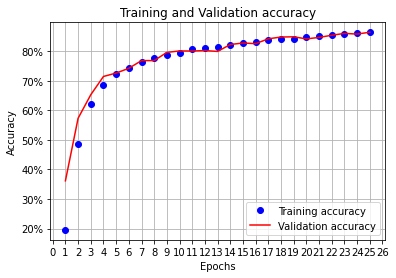

In [61]:
epochs = np.arange(25)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.figure()
plt.plot(epochs, train_acc, 'bo',label='Training accuracy')
plt.plot(epochs, val_acc, 'r',label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()


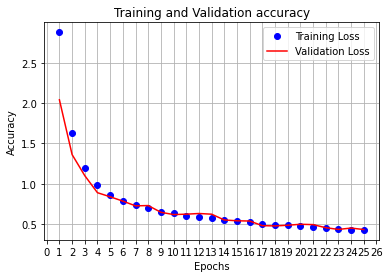

In [66]:
epochs = np.arange(25)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.figure()
plt.plot(epochs, train_loss, 'bo',label='Training Loss')
plt.plot(epochs, val_loss , 'r',label='Validation Loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid('off')
plt.show()

---